In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import wrangle
import env

from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

df = wrangle.wrangle_telco().set_index("customer_id")
X = df.loc[:, ("tenure", "monthly_charges")]
y = pd.DataFrame(df.total_charges)


In [2]:
df.head()

,tenure,monthly_charges,total_charges
customer_id,,,
0013-SMEOE,71,109.70,7904.25
0014-BMAQU,63,84.65,5377.80
0016-QLJIS,65,90.45,5957.90
0017-DINOC,54,45.20,2460.55
0017-IUDMW,72,116.80,8456.75


In [25]:
# split dataframe into train(train_percent: 80%) & test(20%)
def split_my_data(df):
    train, test = train_test_split(df, train_size = 0.8, random_state = 123)
    
    # assign variable vs target
    X_train = train.drop(columns = 'total_charges')
    y_train = train.total_charges
    
    X_test = test.drop(columns = 'total_charges')
    y_test = test.total_charges

    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = split_my_data(df)

In [27]:
X_train.head()

,tenure,monthly_charges
customer_id,,
0707-HOVVN,70,75.50
8380-MQINP,55,20.30
2307-FYNNL,65,109.05
6797-LNAQX,70,98.30
8879-XUAHX,71,116.25


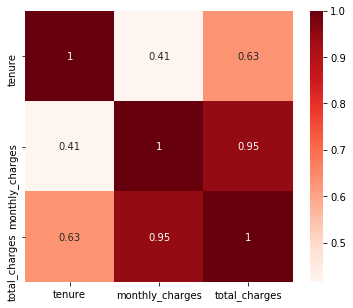

In [36]:
plt.figure(figsize=(6,5))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [38]:
df.describe()

,tenure,monthly_charges,total_charges
count,1685.00000,1685.000000,1685.000000
mean,57.07181,60.872374,3728.933947
std,17.72913,34.712210,2571.252806
min,1.00000,18.400000,20.350000
25%,48.00000,24.050000,1278.800000
50%,64.00000,64.450000,3623.950000
75%,71.00000,90.550000,5999.850000
max,72.00000,118.750000,8672.450000


Write a function, select_kbest_chisquared() that takes X_train, y_train and k as input (X_train and y_train should not be scaled!) and returns a list of the top k features.



In [51]:
def perform_standard_scaler(train, test):
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(train)
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, test_scaled


sc, train_sc, test_sc = perform_standard_scaler(train, test)

In [63]:
def perform_uniform_scaler(train, test):
    u_scaler = QuantileTransformer(n_quantiles=100, output_distribution='uniform', random_state=123, copy=True).fit(train)
    u_train_scaled = pd.DataFrame(u_scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    u_test_scaled = pd.DataFrame(u_scaler.transform(test), columns=test.columns.values).set_index([test.index.values])

    return u_scaler, u_train_scaled, u_test_scaled
scu, train_scu, test_scu = perform_uniform_scaler(train, test)

In [74]:
def gaussian_scaler(train, test):
    p_scaler = PowerTransformer(method='yeo-johnson', standardize=False, copy=True).fit(train)
    p_train_scaled = pd.DataFrame(p_scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    p_test_scaled = pd.DataFrame(p_scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return p_scaler, p_train_scaled, p_test_scaled
scg, train_scg, test_scg = gaussian_scaler(train, test)

In [77]:
def min_max_scaler(train, test):
	mm_scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(train)
	mm_train_scaled = pd.DataFrame(mm_scaler.transform(train), columns= train.columns.values).set_index([train.index.values])
	mm_test_scaled = pd.DataFrame(mm_scaler.transform(test), columns= test.columns.values).set_index([test.index.values])
	return mm_scaler, mm_train_scaled, mm_test_scaled
scmm, train_scmm, test_scmm = min_max_scaler(train, test)

In [82]:
def iqr_robust_scaler(train, test):
    r_scaler = RobustScaler(quantile_range=(25.0,75.0), copy=True, with_centering=True, with_scaling=True).fit(train)
    r_train_scaled = pd.DataFrame(r_scaler.transform(train), columns= train.columns.values).set_index([train.index.values])
    r_test_scaled = pd.DataFrame(r_scaler.transform(test), columns= test.columns.values).set_index([test.index.values])
    return r_scaler, r_train_scaled, r_test_scaled
scr, train_scr, test_scr = iqr_robust_scaler(train, test)

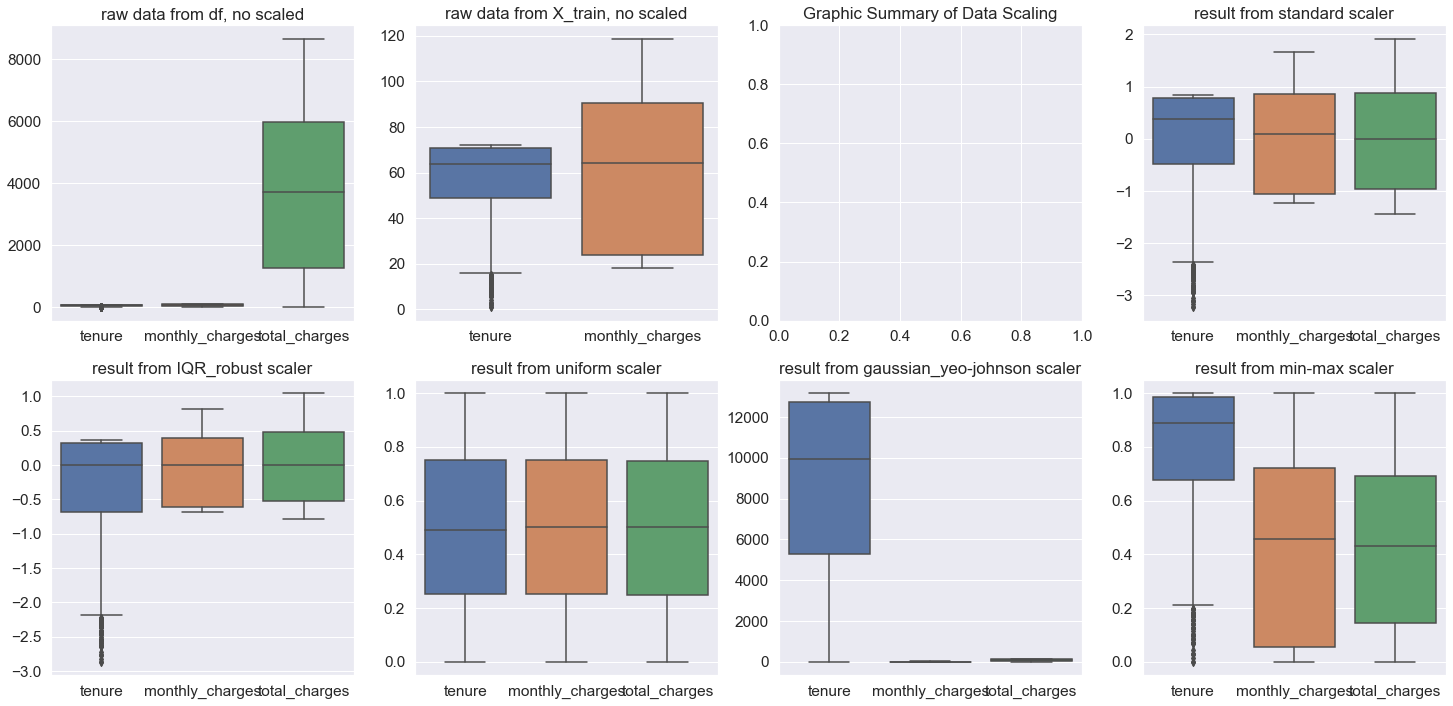

In [90]:
from matplotlib import gridspec

fig = plt.figure(figsize=(25, 25))
gs = gridspec.GridSpec(4, 4)
sns.set(font_scale=1.4)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 3])
ax4 = plt.subplot(gs[1, 1])
ax5 = plt.subplot(gs[1, 2])
ax6 = plt.subplot(gs[1, 3])
ax7 = plt.subplot(gs[1, 0])
ax8 = plt.subplot(gs[0, 2])


ax1.set_title("raw data from df, no scaled")
ax2.set_title("raw data from X_train, no scaled")
ax3.set_title("result from standard scaler")
ax4.set_title("result from uniform scaler")
ax5.set_title("result from gaussian_yeo-johnson scaler")
ax6.set_title("result from min-max scaler")
ax7.set_title("result from IQR_robust scaler")
ax8.set_title("Graphic Summary of Data Scaling")

sns.boxplot(data=train, ax = ax1)
sns.boxplot(data=X_train, ax = ax2)
sns.boxplot(data=train_sc, ax = ax3)
sns.boxplot(data = train_scu, ax = ax4)
sns.boxplot(data = train_scg, ax = ax5)
sns.boxplot(data = train_scmm, ax = ax6)
sns.boxplot(data = train_scr, ax = ax7)



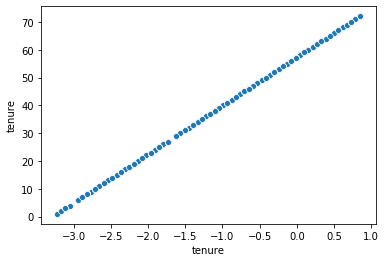

In [57]:
sns.scatterplot(x = train_sc.tenure, y = train.tenure)

In [92]:
train_scu.head()

,tenure,monthly_charges,total_charges
0707-HOVVN,0.686869,0.580710,0.657682
8380-MQINP,0.323232,0.181818,0.181987
2307-FYNNL,0.515152,0.898309,0.872947
6797-LNAQX,0.686869,0.800304,0.850193
8879-XUAHX,0.752525,0.987325,0.995336


In [112]:
def select_kbest_freg(X_train, y_train, k): #no1 unscaled #no2 scaled()
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression

    f_selector = SelectKBest(f_regression, k=2)
    f_selector.fit(X_train,y_train)
    f_support = f_selector.get_support()

    f_feature = X_train.loc[:,f_support].columns.tolist()
    
    feature_nonscale = f_feature
    p_val_nonscale = f_selector.pvalues_
    return feature_nonscale, p_val_nonscale

feature_nonscale, p_val_nonscale = select_kbest_freg(X_train, y_train, 2) 
feature_nonscale, p_val_nonscale

(['tenure', 'monthly_charges'], array([2.8954156e-150, 0.0000000e+000]))

In [114]:
X_train_scu = train_scu.drop(columns = "total_charges")
y_train_scu = train_scu[["total_charges"]]

X_test_scu = test_scu.drop(columns = "total_charges")
y_test_scu = test_scu[["total_charges"]]

In [128]:
def select_kbest_freg(X_train_scu, y_train_scu, k): 
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression

    f_selector = SelectKBest(f_regression, k=2)
    f_selector.fit(X_train_scu,y_train_scu)
    f_support = f_selector.get_support()

    f_feature = X_train_scu.loc[:,f_support].columns.tolist()
    feature_scaled = f_feature
    p_val_scaled = f_selector.pvalues_
    return feature_scaled, p_val_scaled
#     print(f_selector.pvalues_)
#     print(str(len(f_feature)), 'selected features')
#     print(f_feature)

feature_scaled, p_val_scaled = select_kbest_freg(X_train_scu, y_train_scu, 2) 
feature_scaled, p_val_scaled
# [2.8954156e-150 0.0000000e+000]
# 2 selected features
# ['tenure', 'monthly_charges']

(['tenure', 'monthly_charges'], array([6.00594513e-193, 0.00000000e+000]))

In [113]:
#     df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
#     df_eval['model_error'] = np.array([SSE, MSE, RMSE])

present_kbest = pd.DataFrame(np.array(["1st Feature", "1st p-value", "2nd Feature", "2nd p-value"]), columns=['metric']).set_index("metric")

present_kbest["un_scaled"] = np.array([feature_nonscale[0], p_val_nonscale[0], feature_nonscale[1], p_val_nonscale[1]])

present_kbest['scaled'] = np.array([feature_scaled[0], p_val_scaled[0], feature_scaled[1], p_val_scaled[1]])

present_kbest

,un_scaled,scaled
metric,,
1st Feature,tenure,tenure
1st p-value,2.895415602153489e-150,6.005945129485199e-193
2nd Feature,monthly_charges,monthly_charges
2nd p-value,0.0,0.0


Write a function, ols_backware_elimination() that takes X_train and y_train (scaled) as input and returns selected features based on the ols backwards elimination method.
Write a function, lasso_cv_coef() that takes X_train and y_train as input and returns the coefficients for each feature, along with a plot of the features and their weights.
Write 3 functions, the first computes the number of optimum features (n) using rfe, the second takes n as input and returns the top n features, and the third takes the list of the top n features as input and returns a new X_train and X_test dataframe with those top features , recursive_feature_elimination() that computes the optimum number of features (n) and returns the top n features.

In [ ]:
def ols_backware_elimination(X_train, y_train (scaled)):
    return selected features based on the ols backwards elimination method

In [ ]:
def lasso_cv_coef(X_train, y_train): 
    plot(features & their weights)
    return the coefficients for each feature, 

In [ ]:
def #computes the number of optimum features (n) using rfe:

def (input = computes the number of optimum features, n):
    return top n features

def (list of the top n features)
    return new X_train new X_test dataframe: with those top features 

# FINAL
def recursive_feature_elimination() 
# computes the optimum number of features (n) 
# returns the top n features.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()

#Initializing RFE model, with parameter to select top 2 features. 
rfe = RFE(model, 2)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)

print(rfe.support_)
print(rfe.ranking_)

In [ ]:
number_of_features_list=np.arange(1,3)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

# output 
# Optimum number of features: 2
# Score with 2 features: 0.965926

In [ ]:
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 2)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

# output
# Index(['exam1', 'exam3'], dtype='object')